In [1]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import numpy as np
import sklearn
import mne_icalabel
import matplotlib.pyplot as plt

Open BDF file

In [2]:
raw = mne.io.read_raw_bdf("/Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf", preload = True)

Extracting EDF parameters from /Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401407  =      0.000 ...   196.000 secs...


Get Events through trigger(Status) channel

In [3]:
events = mne.find_events(raw, stim_channel = "Status", shortest_event = 1)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15 events found on stim channel Status
Event IDs: [2]


Remove unused BioSemi channels

In [4]:
keep_ch = raw.ch_names[:32] + ["Status"]
raw = raw.pick(keep_ch)

Deleta data recorded before the experiment starts

In [5]:
first_stim = events[events[:, 2] == 2][0, 0] #find the first "code 2" event in frames
last_stim = events[events[:, 2] == 2][-1, 0]
first_stim_time = raw.times[first_stim]
last_stim_time = raw.times[last_stim]
start_time = max(2.0, first_stim_time - 2.0)
end_time = min(raw.times[-1], last_stim_time  + 1.5  # stim duration
                                              + 3.0  # extra time until resting state screen closes
                                              + 0.3) # extra time to be sure    

raw.crop(tmin = start_time, tmax = end_time)

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MB, data loaded>

Drift removal

In [6]:
filt_raw = raw.copy().pick_types(eeg = True).filter(l_freq = 1.0, h_freq = 100.0)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


Plot bug fix

In [7]:
plt.ion()

Random state

Spectrum Analysis / Remove power line noise

In [47]:
psd = filt_raw.compute_psd(fmin = 40, fmax = 60)
freqs = psd.freqs
psd_data = psd.get_data()

#Get index for 50Hz data and neighboring frequencies 
idx_50 = np.argmin(np.abs(freqs - 50))
idx_left = np.where((freqs >= 40) & (freqs < 48))[0]
idx_right = np.where((freqs > 52) & (freqs <= 60))[0]

#Get mean power for the frequencies and calculate the ratio: 50Hz / neighbors
power_50 = psd_data[:, idx_50].mean()
power_neighbors = np.concatenate([psd_data[:, idx_left], psd_data[:, idx_right]], axis = 1).mean()
power_ratio = power_50 / (power_neighbors + 1e-15) #No Divide by 0 error

if power_ratio > 2 :
    filt_raw.notch_filter(freqs = (50,100,150), method = "spectrum_fit")


Effective window size : 1.000 (s)
Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 1056 windows
    100.00 : 1056 windows
    150.00 : 1056 windows


Set up CAR and filter to get ready for icalabel

In [10]:
filt_raw = filt_raw.set_eeg_reference("average", projection = False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Artifact removal 

In [14]:
ica = ICA(n_components = 0.999, max_iter = "auto", method = "infomax", fit_params = dict(extended = True), random_state = 18) # 0.999 to show variance
ica.fit(filt_raw)
ica

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 28 components
Computing Extended Infomax ICA
Fitting ICA took 24.8s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,186 iterations on raw data (350212 samples)
ICA components,28
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


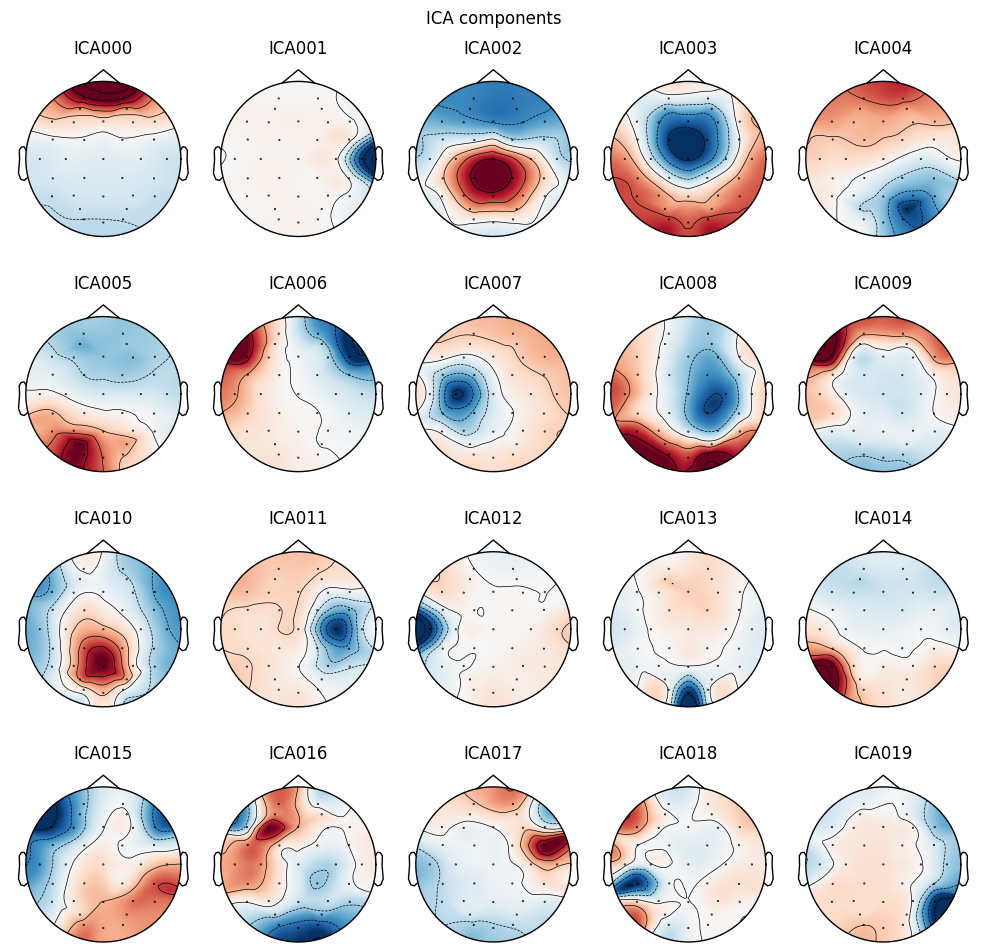

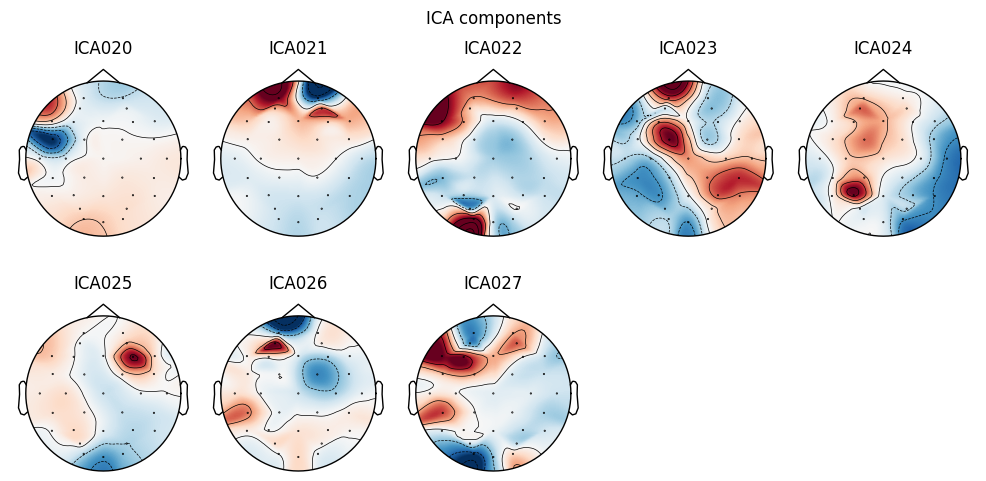

In [ ]:
montage = mne.channels.make_standard_montage(kind = "biosemi32")

rename_dict = dict(zip(filt_raw.ch_names, montage.ch_names)) #rename raw_data channel names to match the 
filt_raw.rename_channels(rename_dict)                        #biosemi32 channel names

#rename_dict = dict(zip(raw.ch_names, montage.ch_names)) Tried plotting the raw data(bad idea)
#raw.rename_channels(rename_dict) 

filt_raw.set_montage(montage)

EOG artifacts with Fp reference

In [17]:
eog_inds, eog_scores = ica.find_bads_eog(filt_raw, ch_name = ["Fp1", "Fp2"])
if eog_inds:
    eog_inds = [int(x) for x in eog_inds]

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


ICALABEL to label ica components

In [18]:
ica_labels = mne_icalabel.label_components(filt_raw, ica, method = "iclabel")

/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: divide by zero encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: overflow encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: invalid value encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _co

Compare EOG and ICALABEL results for eye-blink artifacts

In [ ]:
iclabel_eye_components = [i for i, label in enumerate(ica_labels["labels"]) if label == "eye blink"]
overlap = set(iclabel_eye_components) & set(eog_inds)
only_iclabel = set(iclabel_eye_components) - set(eog_inds)
only_find_bads = set(eog_inds) - set(iclabel_eye_components)

overlap: {0}
Only in ICLabel: {12, 21, 6}
Only in find_bads_eog: set()


Find correct eog components

In [22]:
if bool(overlap) == 0:
    if eog_inds:
        eog_components = eog_inds
    else:
        eog_components = iclabel_eye_components
else:
    eog_components = list(overlap)

Artifact components to exclude

In [23]:
exclude_comp =  [i for i, label in enumerate(ica_labels["labels"]) if label not in ["brain", "other", "eye blink"]] + eog_components
exclude_comp.sort()

Resample

In [ ]:
#filt_raw.filter(h_freq = 70.0)
#filt_raw.resample(256)

Epoch

In [ ]:
#epochs = mne.Epochs(filt_raw, events = "Status", tmin = -0.3, tmax = 2.3, baseline = (None, 0), preload = True)

Export to CSV file 